In [175]:
import os
import vrplib
import math
import numpy as np
import copy
import random
import time
import matplotlib.pyplot as plt
import pandas as pd

In [176]:
instances = [
    ('C101', 'instances/C101.vrp'),
    ('R102', 'instances/R102.vrp'),
    ('RC201', 'instances/RC201.vrp')
]

In [177]:
instances_data = []

for name, path in instances:
    if os.path.exists(path):
        instance = vrplib.read_instance(path, instance_format='solomon')
        instances_data.append((name, instance))
    else:
        print(f"File {path} does not exist.")

In [178]:
def read_optimal_solution(name):
    """Read optimal solution using vrplib"""
    try:
        sol_path = f"instances/{name}.sol"
        solution_data = vrplib.read_solution(sol_path)
        return solution_data
    except:
        return None

In [179]:
def calculate_distance_matrix(instance):
    """
    Calculate the Euclidean distance matrix from VRPLIB instance coordinates.
    
    Parameters:
    instance (dict): VRPLIB instance dictionary containing 'node_coord' key
    
    Returns:
    numpy.ndarray: distance matrix where element (i, j) is distance between nodes i and j
    """
    # Extract coordinates from instance
    coords = instance['node_coord']
    n = len(coords)
    
    # Initialize distance matrix
    distance_matrix = np.zeros((n, n))
    
    # Calculate Euclidean distances
    for i in range(n):
        for j in range(n):
            if i != j:
                dx = coords[i][0] - coords[j][0]
                dy = coords[i][1] - coords[j][1]
                distance_matrix[i][j] = math.sqrt(dx*dx + dy*dy)
    
    return distance_matrix

In [180]:
def initial_solution(instance, distance_matrix):
    """
    Generate initial solution using Solomon Sequential Insertion heuristic for CVRPTW.
    Parameters:
      instance (dict): VRPLIB instance
      distance_matrix (np.ndarray): distance matrix
    Returns:
      list of routes (each route: list of node indices, starting/ending with depot 0)
    """
    n = len(instance['node_coord'])
    capacity = instance['capacity']
    demands = [instance['demand'][i] for i in range(n)]
    time_windows = [tuple(instance['time_window'][i]) for i in range(n)]
    service_times = [instance['service_time'][i] for i in range(n)]
    unvisited = set(range(1, n))  # Clients (exclude depot 0)
    routes = []
    
    while unvisited:
        # Choisir le client avec la fenêtre la plus tôt comme seed
        seed = min(unvisited, key=lambda i: time_windows[i][0])
        route = [0, seed]
        current_load = demands[seed]
        # Service time au seed
        current_time = max(time_windows[0][0] + distance_matrix[0][seed], time_windows[seed][0]) + service_times[seed]
        current_node = seed
        unvisited.remove(seed)
        
        while True:
            best_increase = float('inf')
            best_pos = None
            best_client = None
            # Tenter d'insérer chaque client non visité, à chaque position possible
            for client in unvisited:
                # Check capacity
                if current_load + demands[client] > capacity:
                    continue
                # Essayer toutes les positions possibles dans la tournée
                for insert_pos in range(1, len(route)+1):
                    test_route = route[:insert_pos] + [client] + route[insert_pos:]
                    # Simulation pour voir si tous les clients respectent la time window
                    feasible, finish_time = True, time_windows[0][0]
                    load = 0
                    t = time_windows[0][0]
                    for idx in range(1, len(test_route)):
                        prev = test_route[idx-1]
                        node = test_route[idx]
                        load += demands[node] if node != 0 else 0
                        travel = distance_matrix[prev][node]
                        arr = t + travel
                        # Time window respect
                        start_service = max(arr, time_windows[node][0])
                        if start_service > time_windows[node][1]:
                            feasible = False
                            break
                        t = start_service + (service_times[node] if node != 0 else 0)
                    # Check load also during the test
                        if load > capacity:
                            feasible = False
                            break
                    # Retour au dépôt
                    if len(test_route) > 2:
                        return_depot_time = t + distance_matrix[test_route[-1]][0]
                        if return_depot_time > time_windows[0][1]:
                            feasible = False
                    # Calcul du coût d'insertion
                    if feasible:
                        extra_dist = (distance_matrix[route[insert_pos-1]][client] +
                                      distance_matrix[client][route[insert_pos if insert_pos < len(route) else 0]]) -\
                                     distance_matrix[route[insert_pos-1]][route[insert_pos if insert_pos < len(route) else 0]]
                        if extra_dist < best_increase:
                            best_increase = extra_dist
                            best_pos = insert_pos
                            best_client = client
            if best_client is not None and best_pos is not None:
                # Insère le meilleur client à la meilleure position
                route = route[:best_pos] + [best_client] + route[best_pos:]
                current_load += demands[best_client]
                unvisited.remove(best_client)
            else:
                break  # Can't insert more
        # Fermer la tournée en revenant au dépôt
        route.append(0)
        routes.append(route)
    return routes


In [181]:
# Function to evaluate a given solution (set of routes) for CVRPTW
# Returns: total_distance (float), feasible (bool)
def evaluate_solution(routes, instance, distance_matrix):
    """
    Evaluate the total cost (distance) and feasibility of a CVRPTW solution.
    routes: list of routes (each route: list of node indices)
    instance: dictionary with instance data
    distance_matrix: np.ndarray with distances
    """
    capacity = instance['capacity']
    demands = instance['demand']
    time_windows = instance['time_window']
    service_times = instance['service_time']
    depot_tw = time_windows[0]

    total_distance = 0.0
    feasible = True

    for route in routes:
        load = 0
        time = depot_tw[0]
        prev_node = 0  # depot

        for idx, node in enumerate(route[1:], 1):  # skip depot at start
            # Accumulate demand, skip depot at the end
            if node != 0:
                load += demands[node]
                if load > capacity:
                    feasible = False
            # Travel
            distance = distance_matrix[prev_node][node]
            total_distance += distance
            # Arrive at node
            arrival = time + distance
            window_start, window_end = time_windows[node]
            # Wait if early
            start_service = max(arrival, window_start)
            if start_service > window_end:
                feasible = False
            # Update time
            time = start_service
            if node != 0:
                time += service_times[node]
            prev_node = node
        # Check if returned to depot on time
        if time > depot_tw[1]:
            feasible = False
    return total_distance, feasible


In [182]:
def random_local_move(routes):
    """
    Randomly selects and applies one of: relocation, swap, or 2-opt.
    Returns: new_routes, description_of_move
    """
    move_type = random.choice(["relocation", "swap", "2opt"])
    n_routes = len(routes)
    # Defensive deep copy
    new_routes = copy.deepcopy(routes)

    if move_type == "relocation":
        # Select source route with at least two customers (not just depots)
        candidate_routes = [i for i, rt in enumerate(routes) if len(rt) > 3]
        if len(candidate_routes) < 1:
            return routes, ("relocation_none",)
        src = random.choice(candidate_routes)
        # Pick random customer (not depot)
        cust_positions = list(range(1, len(routes[src]) - 1))
        cust_pos = random.choice(cust_positions)
        customer = routes[src][cust_pos]
        # Remove from source
        new_routes[src].pop(cust_pos)
        # Select target route (could be same as source)
        tgt = random.randrange(n_routes)
        insert_pos = random.randint(1, len(new_routes[tgt]) - 1)
        new_routes[tgt].insert(insert_pos, customer)
        move = ("relocation", src, cust_pos, tgt, insert_pos, customer)
        return new_routes, move

    elif move_type == "swap":
        # Pick two different routes (with at least 1 non-depot)
        possible_routes = [i for i, rt in enumerate(routes) if len(rt) > 3]
        if len(possible_routes) < 2:
            return routes, ("swap_none",)
        r1, r2 = random.sample(possible_routes, 2)
        pos1 = random.choice(range(1, len(routes[r1]) - 1))
        pos2 = random.choice(range(1, len(routes[r2]) - 1))
        # Swap customers
        new_routes[r1][pos1], new_routes[r2][pos2] = new_routes[r2][pos2], new_routes[r1][pos1]
        move = ("swap", r1, pos1, r2, pos2)
        return new_routes, move

    elif move_type == "2opt":
        # Pick a route to 2-opt, requires at least 4 nodes
        candidate_routes = [i for i, rt in enumerate(routes) if len(rt) > 3]
        if not candidate_routes:
            return routes, ("2opt_none",)
        route_idx = random.choice(candidate_routes)
        route = new_routes[route_idx]
        n = len(route)
        # Randomly pick segment [i,j] with 0 < i < j < n-1
        i = random.randint(1, n - 3)
        j = random.randint(i + 1, n - 2)
        new_routes[route_idx] = route[:i] + route[i:j+1][::-1] + route[j+1:]
        move = ("2opt", route_idx, i, j)
        return new_routes, move

    # Fallback: nothing done
    return routes, ("none",)


In [183]:
def relocation_move(routes):
    new_routes = copy.deepcopy(routes)
    candidate_routes = [i for i, rt in enumerate(routes) if len(rt) > 3]
    if len(candidate_routes) < 1:
        return routes, ("relocation_none",)
    src = random.choice(candidate_routes)
    cust_positions = list(range(1, len(routes[src]) - 1))
    cust_pos = random.choice(cust_positions)
    customer = routes[src][cust_pos]
    new_routes[src].pop(cust_pos)
    targets = [i for i in range(len(routes)) if i != src]
    if not targets:
        return routes, ("relocation_none",)
    tgt = random.choice(targets)
    insert_pos = random.randint(1, len(new_routes[tgt]) - 1)
    new_routes[tgt].insert(insert_pos, customer)
    move = ("relocation", src, cust_pos, tgt, insert_pos, customer)
    return new_routes, move


def swap_move(routes):
    possible_routes = [i for i, rt in enumerate(routes) if len(rt) > 3]
    if len(possible_routes) < 2:
        return routes, ("swap_none",)
    r1, r2 = random.sample(possible_routes, 2)
    pos1 = random.choice(range(1, len(routes[r1]) - 1))
    pos2 = random.choice(range(1, len(routes[r2]) - 1))
    new_routes = copy.deepcopy(routes)
    new_routes[r1][pos1], new_routes[r2][pos2] = new_routes[r2][pos2], new_routes[r1][pos1]
    move = ("swap", r1, pos1, r2, pos2)
    return new_routes, move


def multi_relocation(routes):
    new_routes = copy.deepcopy(routes)
    candidate_routes = [i for i, rt in enumerate(routes) if len(rt) > 5]  # At least 3 clients for multi
    if not candidate_routes:
        return routes, ("multi_relocation_none",)
    src = random.choice(candidate_routes)
    route_length = len(routes[src])
    if route_length <= 5:
        return routes, ("multi_relocation_none",)
    max_block = min(3, route_length - 2)  # Up to 3 clients
    block_size = random.randint(2, max_block)
    start_pos = random.randint(1, route_length - block_size - 1)
    block = routes[src][start_pos:start_pos + block_size]
    del new_routes[src][start_pos:start_pos + block_size]
    targets = [i for i in range(len(routes)) if i != src]
    if not targets:
        return routes, ("multi_relocation_none",)
    tgt = random.choice(targets)
    insert_pos = random.randint(1, len(new_routes[tgt]) - 1)
    new_routes[tgt][insert_pos:insert_pos] = block
    move = ("multi_relocation", src, start_pos, block_size, tgt, insert_pos, block)
    return new_routes, move


def multi_swap(routes):
    candidate_routes = [i for i, rt in enumerate(routes) if len(rt) > 5]
    if len(candidate_routes) < 2:
        return routes, ("multi_swap_none",)
    r1, r2 = random.sample(candidate_routes, 2)
    n1 = len(routes[r1]) - 2  # exclude depots
    n2 = len(routes[r2]) - 2
    max_block = min(3, n1, n2)
    if max_block < 2:
        return routes, ("multi_swap_none",)
    size = random.randint(2, max_block)
    pos1 = random.randint(1, len(routes[r1]) - size - 1)
    pos2 = random.randint(1, len(routes[r2]) - size - 1)
    # Swap blocks
    new_routes = copy.deepcopy(routes)
    block1 = new_routes[r1][pos1:pos1 + size]
    block2 = new_routes[r2][pos2:pos2 + size]
    new_routes[r1][pos1:pos1 + size] = block2
    new_routes[r2][pos2:pos2 + size] = block1
    move = ("multi_swap", r1, pos1, r2, pos2, size)
    return new_routes, move


def vns_diversification(routes, seed=None):
    """
    Variable Neighborhood Diversification by random choice of action among:
      - relocation_move, swap_move, multi_relocation, multi_swap
    """
    if seed is not None:
        random.seed(seed)
    candidates = [relocation_move, swap_move, multi_relocation, multi_swap]
    move_fn = random.choice(candidates)
    return move_fn(routes)


In [184]:
def tabu_search(initial_routes, distance_matrix, instance, max_iterations=500, tabu_size=15, vns_freq=50, num_neighbors=40):
    """
    Tabu Search for CVRPTW, with VNS and 2-opt local search.
    Parameters:
      initial_routes: list of initial routes
      ...
    Returns:
      best_routes, best_cost
    """
    # Initialization
    current_routes = [route[:] for route in initial_routes]
    best_routes = [route[:] for route in initial_routes]
    best_cost, feasible = evaluate_solution(best_routes, instance, distance_matrix)
    if not feasible:
        print("Warning: Initial solution is infeasible!")
    tabu_list = []  # List of recent moves
    iter_counter = 0
    cost_history = [best_cost]
    current_cost_history = [best_cost]
    
    while iter_counter < max_iterations:
        # 1. Generate neighborhood (e.g., 2-opt on all routes + swaps between routes)
        neighbors = []
        moves = []
        for _ in range(num_neighbors):
            # Intensification
            new_routes, move = random_local_move(current_routes)
            neighbors.append(new_routes)
            moves.append(move)
            # Diversification
            if vns_freq > 0 and iter_counter % vns_freq == 0:
                vns_routes, vns_move = vns_diversification(current_routes)
                neighbors.append(vns_routes)
                moves.append(vns_move)
        
        # 2. Evaluate neighbors
        candidate_best = None
        candidate_cost = float('inf')
        candidate_move = None
        for neigh, move in zip(neighbors, moves):
            cost, feasible = evaluate_solution(neigh, instance, distance_matrix)
            if feasible:
                if move not in tabu_list or cost < best_cost:  # Aspiration
                    if cost < candidate_cost:
                        candidate_best = neigh
                        candidate_cost = cost
                        candidate_move = move
        # If no feasible candidate found
        if candidate_best is None:
            # print("No feasible neighbor, random restart or intensify diversification.")
            # Can implement random restart or force VNS
            iter_counter += 1
            continue
        # 3. Move to best candidate
        current_routes = [route[:] for route in candidate_best]
        # Update Tabu list
        tabu_list.append(candidate_move)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)
        # Update global best if improved
        if candidate_cost < best_cost:
            best_cost = candidate_cost
            best_routes = [route[:] for route in candidate_best]
        current_cost = candidate_cost
        cost_history.append(best_cost)
        current_cost_history.append(current_cost)
        iter_counter += 1
    return best_routes, best_cost, cost_history, current_cost_history




Instance C101
Initial solution: Cost = 878.36, Feasible: True
Tabu Search result: Cost = 878.36
Execution time: 30.14 seconds (0.50 minutes)
Optimal solution: 827.30
Gap: 6.17%
Total improvement: 0.00 (0.00%)
Number of improvements: 0
Number of vehicles: 10
Average capacity per route: 181.00
Average distance per route: 87.84


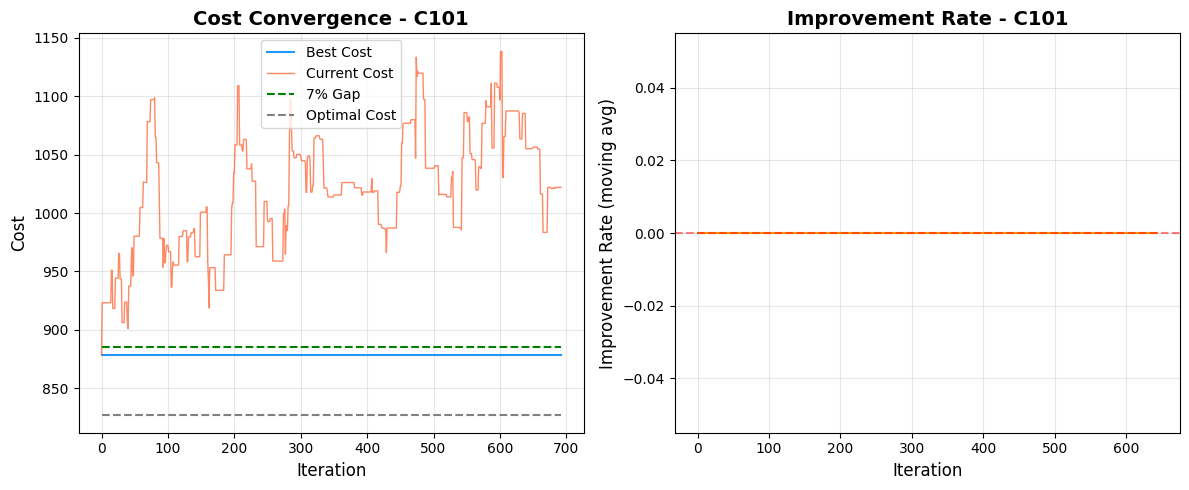

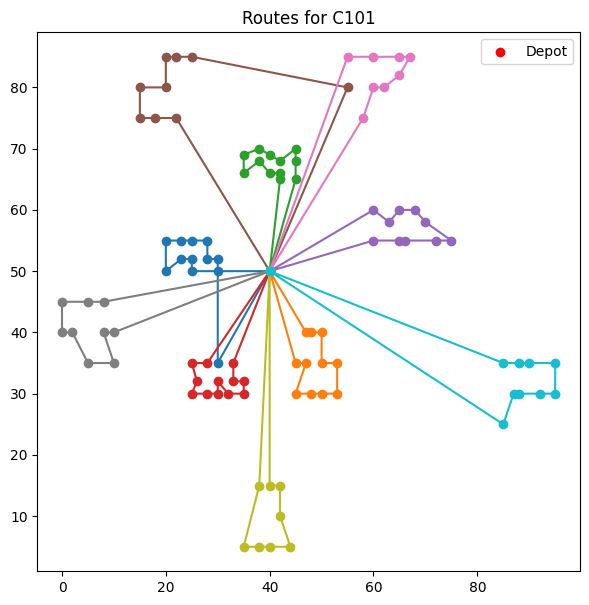



Instance R102
Initial solution: Cost = 2005.55, Feasible: True
Tabu Search result: Cost = 1634.26
Execution time: 36.01 seconds (0.60 minutes)
Optimal solution: 1466.60
Gap: 11.43%
Total improvement: 371.29 (18.51%)
Number of improvements: 87
Average improvement: 4.27
Largest improvement: 22.94
Number of vehicles: 21
Average capacity per route: 69.43
Average distance per route: 77.82


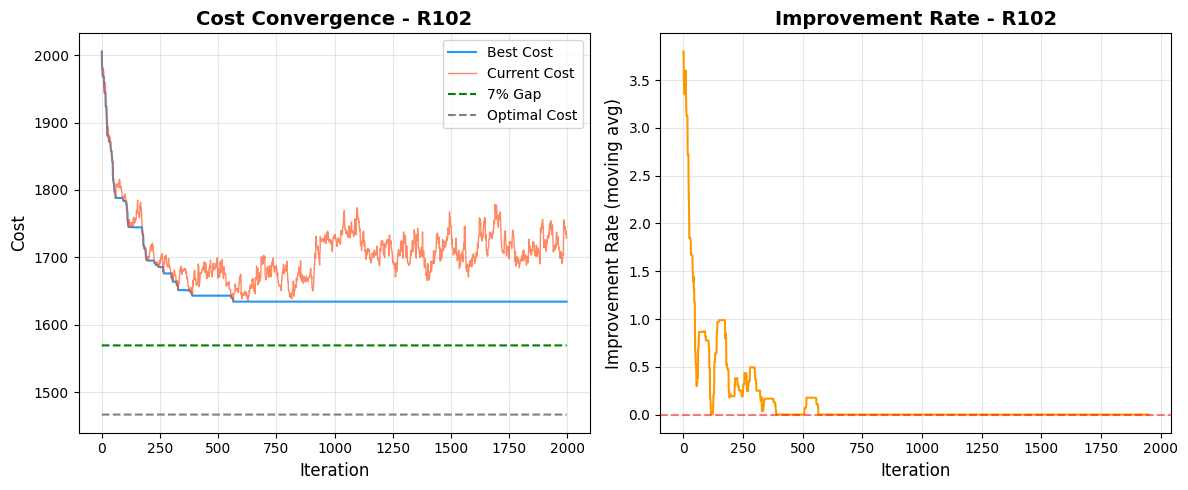

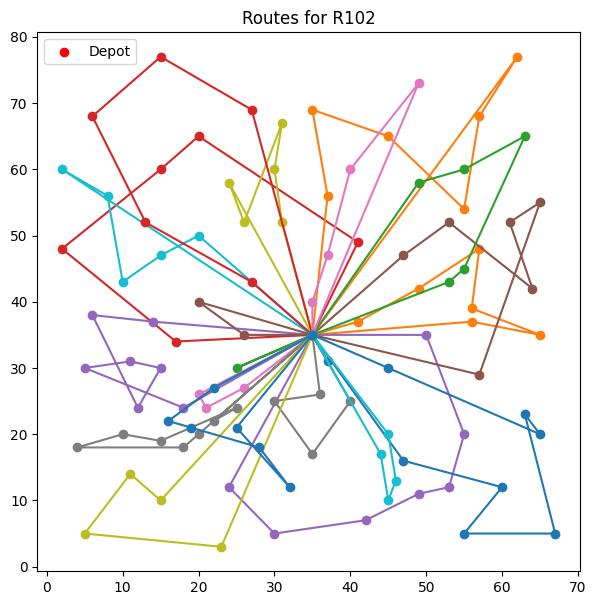



Instance RC201
Initial solution: Cost = 2326.87, Feasible: True
Tabu Search result: Cost = 1608.74
Execution time: 27.36 seconds (0.46 minutes)
Optimal solution: 1261.80
Gap: 27.50%
Total improvement: 718.13 (30.86%)
Number of improvements: 97
Average improvement: 7.40
Largest improvement: 67.96
Number of vehicles: 5
Average capacity per route: 344.80
Average distance per route: 321.75


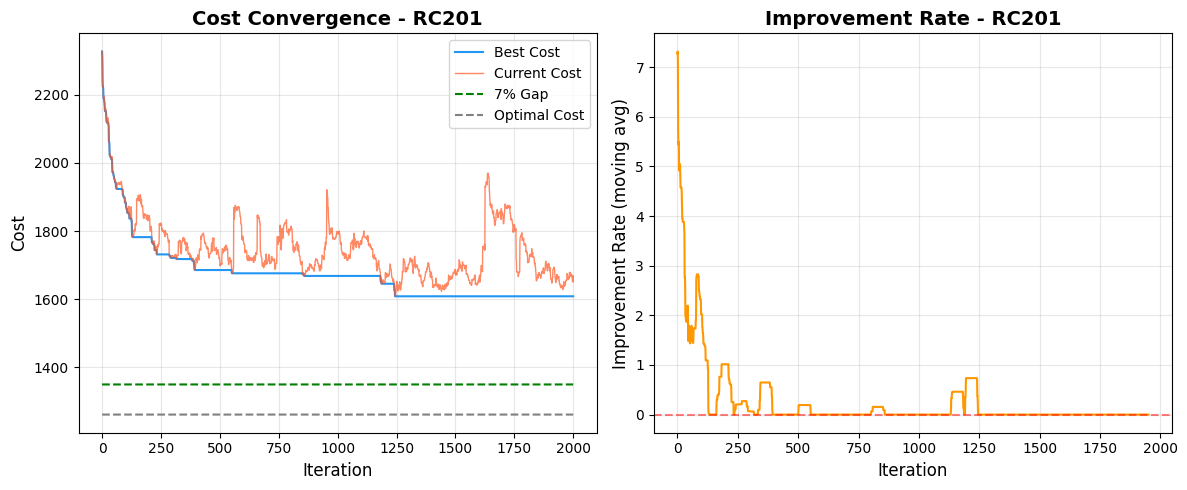

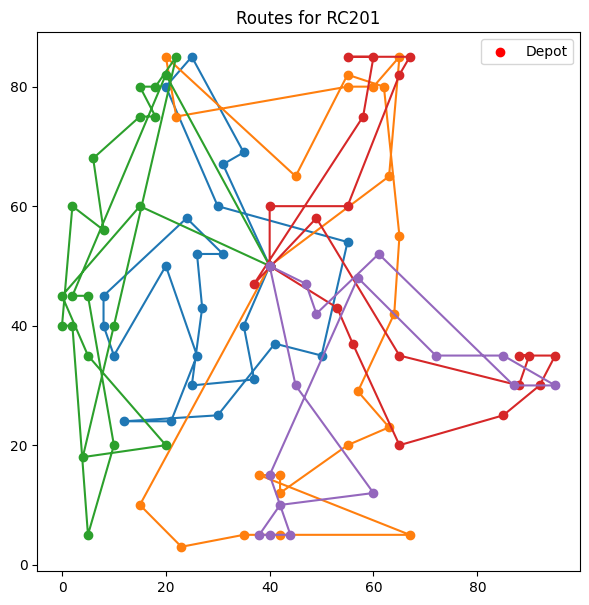


SUMMARY TABLE - FINAL RESULTS

Instance        Optimum cost    Your cost       Gap (%)      Time (s)    
--------------------------------------------------------------------------------
C101            827             878             6.17%        30.1        
R102            1467            1634            11.43%       36.0        
RC201           1262            1609            27.50%       27.4        
--------------------------------------------------------------------------------

Average Gap: 15.03%
Average Time: 31.2s


In [185]:
summary_results = []

for name, instance in instances_data:
    print(f"\n")
    print(f"="*60)
    print(f"Instance {name}")
    print(f"="*60)
    distance_matrix = calculate_distance_matrix(instance)
    initial_routes = initial_solution(instance, distance_matrix)
    initial_cost, initial_feasible = evaluate_solution(initial_routes, instance, distance_matrix)
    print(f"Initial solution: Cost = {initial_cost:.2f}, Feasible: {initial_feasible}")

    start_time = time.time()

    best_routes, best_cost, cost_history, current_cost_history = tabu_search(
        initial_routes,
        distance_matrix,
        instance,
        max_iterations=2000,
        tabu_size=15,
        vns_freq=50,
        num_neighbors=100
    )

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"Tabu Search result: Cost = {best_cost:.2f}")
    print(f"Execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

    opt = read_optimal_solution(name)
    if opt and 'cost' in opt:
        optimal_cost = opt['cost']
        gap = 100 * (best_cost - optimal_cost)/optimal_cost
        gap_cost = optimal_cost * 1.07
        print(f"Optimal solution: {optimal_cost:.2f}")
        print(f"Gap: {gap:.2f}%")
    else:
        print("No optimal solution file available.")

    # Calculate improvement statistics
    improvements = []
    for i in range(1, len(cost_history)):
        if cost_history[i] < cost_history[i-1]:
            improvements.append((i, cost_history[i-1] - cost_history[i]))
    
    print(f"Total improvement: {initial_cost - best_cost:.2f} ({100*(initial_cost-best_cost)/initial_cost:.2f}%)")
    print(f"Number of improvements: {len(improvements)}")
    if improvements:
        print(f"Average improvement: {np.mean([imp for _, imp in improvements]):.2f}")
        print(f"Largest improvement: {max([imp for _, imp in improvements]):.2f}")
    
    nb_vehicules = len(best_routes)
    charges = [sum(instance['demand'][k] for k in route if k != 0) for route in best_routes]
    distances = [sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1)) for route in best_routes]
    print(f"Number of vehicles: {nb_vehicules}")
    print(f"Average capacity per route: {np.mean(charges):.2f}")
    print(f"Average distance per route: {np.mean(distances):.2f}")

    summary_results.append({
        'instance': name,
        'optimal_cost': opt['cost'] if opt and 'cost' in opt else None,
        'your_cost': best_cost,
        'gap': 100 * (best_cost - opt['cost']) / opt['cost'] if opt and 'cost' in opt else None,
        'time': execution_time
    })
    
    # Plot trajectory
    plt.figure(figsize=(12, 5))
    
    # Left: full trajectory
    plt.subplot(1, 2, 1)
    plt.plot(cost_history, linewidth=1.5, color='#2196F3', label='Best Cost')
    plt.plot(current_cost_history, linewidth=1.0, color='#FF5722', alpha=0.7, label='Current Cost')
    plt.plot(gap_cost * np.ones(len(cost_history)), linestyle='--', color='green', label='7% Gap')
    plt.plot(optimal_cost * np.ones(len(cost_history)), linestyle='--', color='gray', label='Optimal Cost')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Cost', fontsize=12)
    plt.title(f'Cost Convergence - {name}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Right: improvement rate (moving average)
    plt.subplot(1, 2, 2)
    improvements_per_iter = [0]
    for i in range(1, len(cost_history)):
        improvements_per_iter.append(cost_history[i-1] - cost_history[i])
    
    window_size = 50
    if len(improvements_per_iter) > window_size:
        moving_avg = np.convolve(improvements_per_iter, np.ones(window_size)/window_size, mode='valid')
        plt.plot(moving_avg, linewidth=1.5, color='#FF9800')
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Improvement Rate (moving avg)', fontsize=12)
    plt.title(f'Improvement Rate - {name}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    coords = np.array(instance['node_coord'])
    plt.figure(figsize=(7,7))
    for route in best_routes:
        xs = coords[route, 0]
        ys = coords[route, 1]
        plt.plot(xs, ys, marker='o')
    plt.scatter(coords[0,0], coords[0,1], color='red', label='Depot')
    plt.title(f'Routes for {name}')
    plt.legend()
    plt.show()

print("\n" + "="*80)
print("SUMMARY TABLE - FINAL RESULTS")
print("="*80)

# Create DataFrame
df = pd.DataFrame(summary_results)

# Format the display
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Print table header with colors (using ANSI codes)
print(f"\n{'Instance':<15} {'Optimum cost':<15} {'Your cost':<15} {'Gap (%)':<12} {'Time (s)':<12}")
print("-" * 80)

# Print each row
for result in summary_results:
    instance = result['instance']
    opt_cost = result['optimal_cost']
    your_cost = result['your_cost']
    gap = result['gap']
    time_s = result['time']
    
    # Format values
    opt_str = f"{opt_cost:.0f}" if opt_cost is not None else "N/A"
    cost_str = f"{your_cost:.0f}"
    gap_str = f"{gap:.2f}%" if gap is not None else "N/A"
    time_str = f"{time_s:.1f}"
    
    print(f"{instance:<15} {opt_str:<15} {cost_str:<15} {gap_str:<12} {time_str:<12}")

print("-" * 80)

# Calculate average gap if available
valid_gaps = [r['gap'] for r in summary_results if r['gap'] is not None]
if valid_gaps:
    avg_gap = sum(valid_gaps) / len(valid_gaps)
    print(f"\nAverage Gap: {avg_gap:.2f}%")

avg_time = sum(r['time'] for r in summary_results) / len(summary_results)
print(f"Average Time: {avg_time:.1f}s")
print("="*80)